In [1]:
import sys
import platform
import torch
import sklearn as s
import numpy as np
import pandas as pd
import os
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import cv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label
from torch.utils.data import random_split
import torchvision.transforms.functional as TF

Task Overview:

Upon reviewing the task at hand, it's evident that it involves image segmentation, with the goal of building a neural network model following the architecture of Unet. This model will incorporate a high-quality classifier in its encoder part. The objective of the model is to classify each pixel of an image as belonging to the object of interest (in our case, the ship class) or classify it as background.

In the context of this task, it's crucial to accurately assess the model's quality to ensure it can effectively detect and segment ships in images. There are several challenges to address in this task, requiring careful consideration and mitigation strategies throughout the model development and evaluation process.

Making import some most important libraries

In [2]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {s.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Windows-10-10.0.19045-SP0
PyTorch Version: 2.2.0

Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas 2.1.4
Scikit-Learn 1.3.0
NVIDIA/CUDA GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


Defining the variables image_path_train and image_path_test, which contain paths to directories with training and test images, respectively.

In [3]:
train_data = os.listdir('D:/загрузки/train_v2')
test_data = os.listdir('D:/загрузки/test_v2')


image_path_train = 'D:/загрузки/train_v2'
image_path_test = 'D:/загрузки/test_v2'


Let's see on submission example

In [4]:
submission = pd.read_csv('D:/загрузки/sample_submission_v2.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


This code loads ship mask data from a CSV file and displays the first few rows of the dataframe for preliminary analysis, as well as information about its size.

In [5]:
mask = pd.read_csv('D:/загрузки/train_ship_segmentations_v2.csv')
display(mask.head(5))
print((mask.shape))

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


(231723, 2)


**This code calculates the number of images with and without ships in the dataset and visualizes this distribution using a bar plot**

Empty images without ships:  150000
Images containing ships:  81723


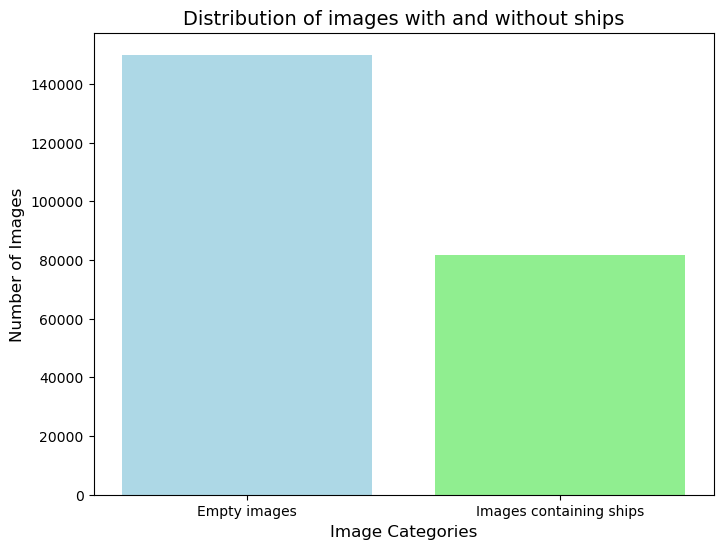

In [6]:
empty_ship = mask['EncodedPixels'].isna().sum()
print('Empty images without ships: ', empty_ship)

Containing_ship = mask['EncodedPixels'].notna().sum()
print('Images containing ships: ', Containing_ship)

# Визуализация
import matplotlib.pyplot as plt

# Список категорий
categories = ['Empty images', 'Images containing ships']
counts = [empty_ship, Containing_ship]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['lightblue', 'lightgreen'])
plt.title('Distribution of images with and without ships', fontsize=14)
plt.xlabel('Image Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

Analysis and Strategy:

Upon reviewing the distribution, it's evident that nearly 65% of the dataset comprises empty images. This imbalance poses a significant challenge, as it could lead to overfitting and biased classification, with most pixels labeled as background.

Given this scenario, a straightforward approach with the original data is not viable. To mitigate the risk of overfitting and ensure accurate classification, we need to address this imbalance. Our strategy will involve reducing the proportion of empty images to manageable levels, thereby creating a more balanced dataset for training our model.

DataFrame Overview:

The DataFrame df encapsulates crucial information related to ship presence on each image:

'ships' Column: Indicates the count of ships on each respective image.

'has_ship' Column: A binary flag denoting whether the image contains at least one ship (1) or none (0).

This DataFrame serves as a fundamental source of information for understanding the distribution of ships across the dataset and identifying images with or without ships, essential for subsequent analysis and model training.

In [7]:
df = mask.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0
...,...,...
fffedbb6b.jpg,0,0
ffff2aa57.jpg,0,0
ffff6e525.jpg,0,0


Data Inspection:

Upon examining the data within this DataFrame, it becomes evident that the masks for our ships are encoded using Run-Length Encoding (RLE) technique.

This observation is crucial for understanding how the ship masks are represented and decoded, facilitating further preprocessing steps and model development tailored to handle RLE-encoded masks effectively.
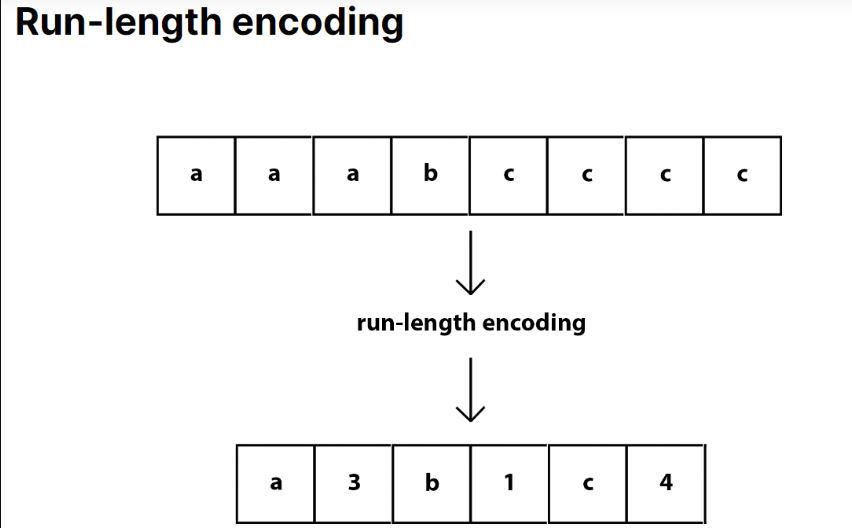
What is run-length encoding?

Run-length encoding (RLE) is a lossless compression method where sequences that display redundant data are stored as a single data value representing the repeated block and how many times it appears in the image. Later, during decompression, the image can be reconstructed exactly from this information.

This type of compression works best with simple images and animations that have a lot of redundant pixels. It's useful for black and white images in particular. For complex images and animations, if there aren't many redundant sections, RLE can make the file size bigger rather than smaller. Thus it's important to understand the content and whether this algorithm will help or hinder.


In [8]:
df_without_ship = mask[mask['EncodedPixels'].notna()]
df_without_ship

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


Data Aggregation and Processing:

This code snippet performs the following operations on the DataFrame mask:

Grouping by ImageIDs:

The data is grouped by the image IDs in the 'ImageId' column, allowing for the aggregation of information for each image.
Counting Ship Instances:

For each image, it calculates the count of non-empty values in the 'EncodedPixels' column, determining the number of ships present in each image.
Renaming Columns:

Renames the resulting column containing the ship count to 'ships' for clarity and consistency.
Creating 'has_ship' Flag:

Adds a new column 'has_ship', which is assigned a value of 1 if the image contains at least one ship (i.e., ship count > 0), and 0 otherwise.
Thus, the resulting DataFrame df contains information about the ship count and a 'has_ship' flag, indicating the presence of ships in each image.

In [9]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [10]:
import pandas as pd
import numpy as np

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def combine_masks(mask_list):
    combined_mask = None
    for mask_rle in mask_list:
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
            if combined_mask is None:
                combined_mask = mask
            else:
                combined_mask |= mask  
    return combined_mask


combined_masks = df_without_ship.groupby('ImageId')['EncodedPixels'].apply(lambda x: combine_masks(x.tolist()))


In [11]:
mask['ships'] = mask['EncodedPixels'].map(lambda x: 1 if not pd.isna(x) else 0)
mask

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [12]:
df = mask.groupby('ImageId').agg({'EncodedPixels': 'count'})
df = df.rename(columns={'EncodedPixels' : 'ships'})
df['has_ship'] = df['ships'].map(lambda x: 1 if x > 0 else 0)
df

,ships,has_ship
ImageId,,
00003e153.jpg,0,0
0001124c7.jpg,0,0
000155de5.jpg,1,1
000194a2d.jpg,5,1
0001b1832.jpg,0,0
...,...,...
fffedbb6b.jpg,0,0
ffff2aa57.jpg,0,0
ffff6e525.jpg,0,0


Counting Ship Instances:

This code snippet performs the following operations:

Counting Unique Ship Counts:

It counts the number of unique values in the 'ships' column of the DataFrame and stores the counts in the variable 'counts'.
Returning a Series:

It returns a Pandas Series containing the count of unique values in the 'ships' column. Each value in this Series represents the number of images with a specific number of ships.

In [13]:
counts = df['ships'].value_counts()
counts.reset_index()
counts


ships
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

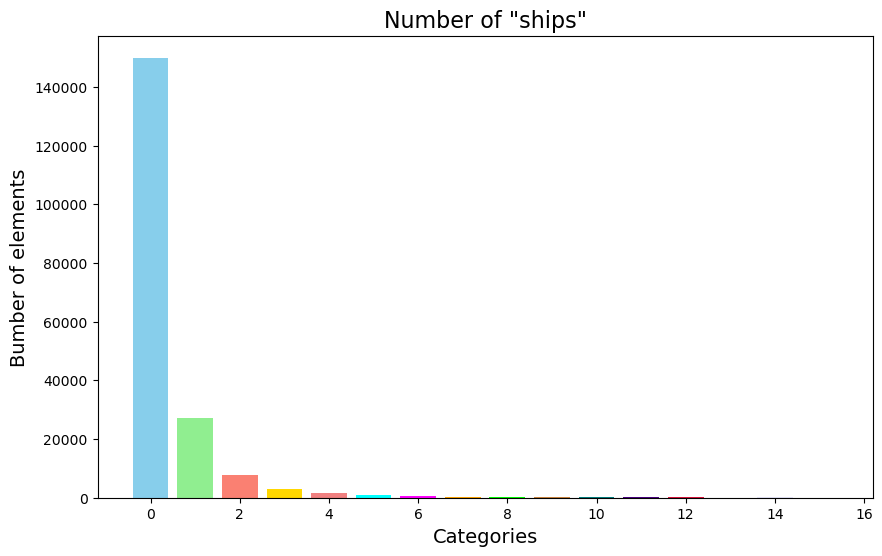

In [14]:
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral', 'cyan', 'magenta', 'orange', 'lime', 'peru', 'teal', 'indigo', 'crimson', 'lavender', 'darkorange', 'lightpink']
plt.bar(counts.index, counts, color=colors)

plt.title('Number of "ships"', fontsize=16)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Bumber of elements', fontsize=14)
plt.show()

In [16]:
def resize_df(group, base_size=1500):
    ship_count = len(group)
    if ship_count == 0:
        return group.sample(base_size // 3)
    elif ship_count > base_size:
        return group.sample(base_size)
    else:
        return group

balance_df = df.groupby('ships').apply(resize_df)
balance_df['ships'].value_counts()

ships
0     1500
1     1500
2     1500
3     1500
4     1500
5      925
6      657
7      406
8      318
9      243
10     168
11     144
12     124
14      76
13      75
15      66
Name: count, dtype: int64

This code aims to balance the dataset based on the count of ships present in each group. It begins by defining a function called resize_df. This function takes a group (which represents a subset of the DataFrame grouped by the number of ships) and a parameter base_size, which defines the desired size of the resulting balanced dataset.

This code aims to balance the dataset based on the count of ships present in each group. It begins by defining a function called resize_df. This function takes a group (which represents a subset of the DataFrame grouped by the number of ships) and a parameter base_size, which defines the desired size of the resulting balanced dataset.

Inside the resize_df function, it calculates the number of ships in the group. If the ship count is zero, indicating there are no ships in the group, it samples a portion of the group to match approximately one-third of the base_size. If the ship count exceeds the base_size, it randomly samples the group down to the base_size. Otherwise, if the ship count is less than or equal to the base_size, it returns the original group unchanged.

After defining the resize_df function, the code utilizes it with the groupby method on the DataFrame df. It groups the data by the count of ships and applies the resize_df function to each group. This results in a balanced DataFrame named balance_df, where the number of ships in each group is adjusted according to the specified base_size.

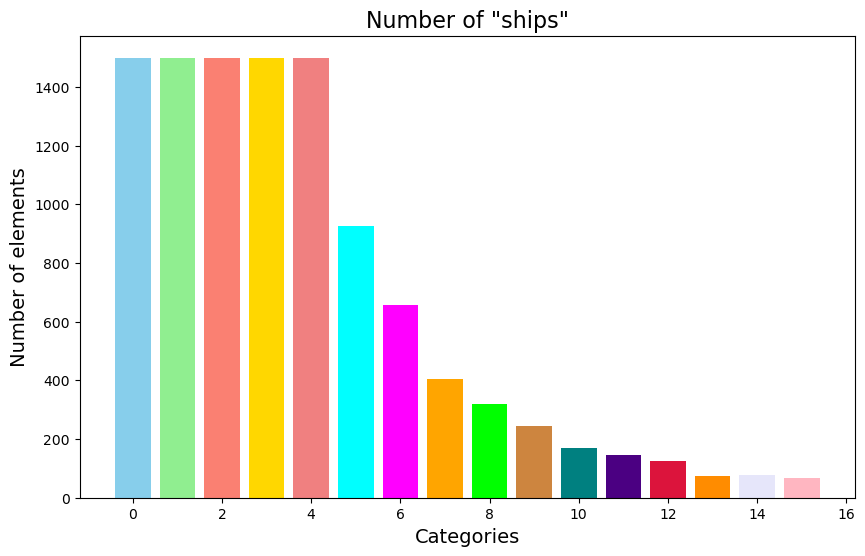

In [17]:
import matplotlib.pyplot as plt

counts_balances = balance_df['ships'].value_counts()
counts_balances.reset_index()

plt.figure(figsize=(10, 6))
plt.bar(counts_balances.index,counts_balances, color=colors)

plt.title('Number of "ships"', fontsize=16)
plt.xlabel('Categories', fontsize=14)
plt.ylabel(' Number of elements ', fontsize=14)
plt.show()

In [18]:
filtered_image_ids = set(mask['ImageId'].unique()) 

train_data_2 = [x for x in train_data if x in filtered_image_ids]
set(train_data_2)
len(train_data_2)

192556

Checking for uniqueness of images in the dataset

In [19]:
filtered_image_ids = set(mask['ImageId'].unique()) 

train_data_2 = [x for x in train_data if x in filtered_image_ids]
set(train_data_2)
len(train_data_2)

192556

In [17]:
combined_masks

ImageId
000155de5.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
000194a2d.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
00021ddc3.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
0002756f7.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
00031f145.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                       ...                        
fff77c602.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fff909871.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffcb6464.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffd924fb.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
fffdd2377.jpg    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: EncodedPixels, Length: 42556, dtype: object

In [18]:
df_combined_masks = pd.DataFrame(combined_masks)
df_combined_masks

,EncodedPixels
ImageId,
000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
fff77c602.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
fff909871.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
fffcb6464.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


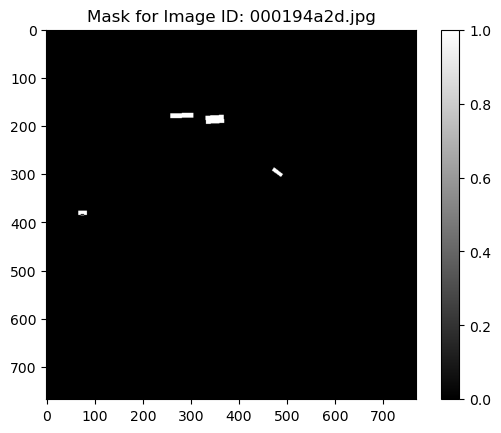

In [19]:
import matplotlib.pyplot as plt

image_id = '000194a2d.jpg'

mask_values = df_combined_masks.loc[image_id].values

mask_array = np.array(mask_values[0])

plt.imshow(mask_array, cmap='gray')
plt.colorbar()  
plt.title('Mask for Image ID: ' + image_id)
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_24800\1842664008.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(combined_masks[1], cmap='gray')


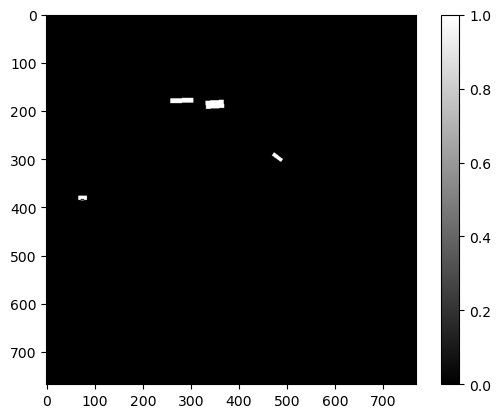

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(combined_masks[1], cmap='gray')
plt.colorbar()
plt.show()


This CustomDataset class is designed to create a PyTorch dataset for image segmentation tasks. Here's a detailed breakdown of its components:

Initialization:

df: DataFrame containing image metadata and ship annotations.
image_dir: Directory path where the images are stored.
transform: Optional image transformation (e.g., normalization, resizing).
image_names: List of image filenames with at least one ship present.
__len__ Method:

Returns the length of the dataset, which is the number of images with ships.
__getitem__ Method:

idx: Index of the dataset to retrieve.
Retrieves the image and mask corresponding to the given index:
Reads the image using PIL and converts it to RGB format.
Retrieves the mask from the DataFrame based on the image name.
Applies transformations to the image and mask if specified.
Binarizes the mask to convert it into a binary mask.
rle_decode Method:

This method is used internally to decode the run-length encoded (RLE) mask format into a binary mask array. It takes a string representing the RLE mask and returns a NumPy array representing the binary mask.
masks_as_image Method:

This method combines multiple ship masks into a single mask array. If multiple masks are available for an image, they are merged into a single binary mask.
The resulting mask array is converted into a PIL Image object and returned.
This dataset class provides a flexible way to load images and masks for segmentation tasks, allowing for easy integration with PyTorch's DataLoader for training neural networks.

Transformations:

transform: Defines a series of transformations to be applied to the images. These transformations include resizing the images to a fixed size of 256x256 pixels and converting them into PyTorch tensors.

mask_transform: Specifies the transformations for the masks. Similar to the transform variable, it resizes the masks to 256x256 pixels and converts them into tensors.

Batch Size:

batch_size: Specifies the number of samples in each batch during training or evaluation. In this case, the batch size is set to 28.

Dataset Creation:

dataset: Creates an instance of the CustomDataset class using the DataFrame mask, which contains information about the images and masks, and the image_path_train directory where the image files are located. Additionally, it applies the transformations defined by the transform parameter.

Length of Dataset:

len(dataset): Returns the total number of samples in the dataset. This value indicates the number of images with at least one ship present, as defined by the CustomDataset class.

In [21]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = df['ImageId'].tolist()
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        
        mask = self.df['EncodedPixels'].iloc[idx]
        mask = Image.fromarray(mask) 

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
            mask = (mask > 0).float()

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
batch_size = 20

df_combined_masks.reset_index(inplace=True)
df_combined_masks.rename(columns={'index': 'ImageId'}, inplace=True)

dataset = CustomDataset(df=df_combined_masks, image_dir=image_path_train, transform=transform)
len(dataset)

42556

In [22]:
class CustomDataset_for_test_data(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_names = os.listdir(self.image_dir)
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
                 
        return image
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_test = CustomDataset_for_test_data(image_dir=image_path_test, transform = transform)
len(dataset_test)

15606

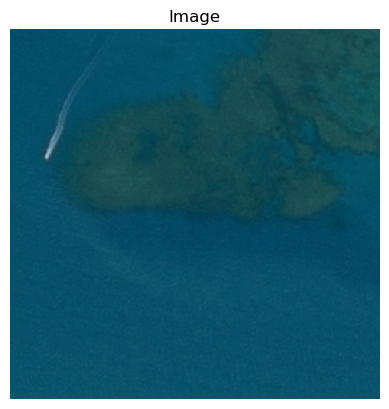

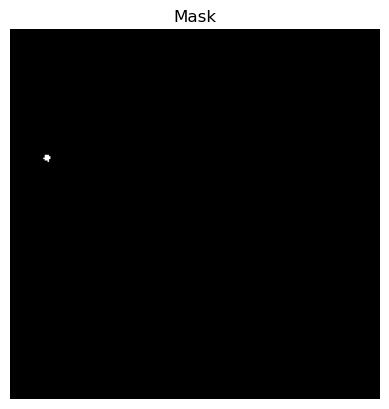

In [23]:
imagee, maskk = dataset[12]

import matplotlib.pyplot as plt
plt.imshow(imagee.permute(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.show()

mask_array = np.array(maskk)
plt.imshow(mask_array.squeeze(), cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()



In [24]:
print(mask_array.shape)


(1, 256, 256)


In [25]:
maskk.unique()

tensor([0., 1.])

In [26]:
size = maskk.size()
size
image_size = imagee.size()
image_size

torch.Size([3, 256, 256])

In [27]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_data_loader = DataLoader(train_dataset, batch_size = 10, shuffle = True, num_workers= 4)
test_data_loader = DataLoader(test_dataset, batch_size = 10, shuffle = True, num_workers= 4)

print(len(train_dataset))
print(len(test_dataset))

34044
8512


In [28]:
# for batch in train_data_loader:

#     batch_size = batch[0].shape[0]
#     channels = batch[0].shape[1]
#     height = batch[0].shape[2]
#     width = batch[0].shape[3]
    
#     batch_size1 = batch[1].shape[0]
#     channels1 = batch[1].shape[1]
#     height1 = batch[1].shape[2]
#     width1 = batch[1].shape[3]
    
#     print(f"Batch size: {batch_size}, Channels: {channels}, Height: {height}, Width: {width}")
#     print(f"Batch size: {batch_size1}, Channels: {channels1}, Height: {height1}, Width: {width1}")
#     break


In [29]:
# for batch in test_data_loader:

#     batch_size = batch[0].shape[0]
#     channels = batch[0].shape[1]
#     height = batch[0].shape[2]
#     width = batch[0].shape[3]
    
#     batch_size1 = batch[1].shape[0]
#     channels1 = batch[1].shape[1]
#     height1 = batch[1].shape[2]
#     width1 = batch[1].shape[3]
    
#     print(f"Batch size: {batch_size}, Channels: {channels}, Height: {height}, Width: {width}")
#     print(f"Batch size: {batch_size1}, Channels: {channels1}, Height: {height1}, Width: {width1}")
#     break


In [30]:
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels,
                      output_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, 
                      output_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  

        # Down part of Unet
        for feature in features:
            self.downs.append(DoubleConv(input_channels, feature))  
            input_channels = feature

        # Up part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2,
                                   feature,
                                   kernel_size=2,
                                   stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1) 

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])  
            concat_skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip_connection)

        return torch.sigmoid(self.final_conv(x))
#         return self.final_conv(x)


# def test():
#     x = torch.rand(size=(32, 1, 256,
#                          256)) 
#     model = Unet(input_channels = 1, output_channels=1)
#     prediction = model(x)
#     print(x.shape)
#     print(prediction.shape)
#     assert prediction.shape == x.shape

# test()
# model = Unet(input_channels=3, output_channels=1)

In [31]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList([
            DoubleConv(input_channels, 32),
            DoubleConv(32, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
            DoubleConv(512, 1024)
        ])
        self.ups = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            DoubleConv(1024, 512),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            DoubleConv(512, 256),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            DoubleConv(256, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            DoubleConv(128, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            DoubleConv(64, 32)
        ])
        self.final_conv = nn.Conv2d(32, output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2)(x)

        x = skip_connections.pop()
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections.pop()
            x = torch.cat((x, skip_connection), dim=1)
            x = self.ups[idx + 1](x)

        return torch.sigmoid(self.final_conv(x))

# Перевірка роботи моделі
input_channels = 3
output_channels = 1
model = UNet(input_channels, output_channels)
print(model)


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (conv):

In [32]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            
            # Преобразуем массивы NumPy обратно в тензоры PyTorch
            dice_score += dice_coef(torch.tensor(y.cpu().detach().numpy()), torch.tensor(preds.cpu().detach().numpy()))

    print(f'Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}')
    print(f'Dice score: {dice_score/len(loader)}')
    model.train()


In [33]:
import torch.nn as nn
import torch

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()  
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection
    return (2. * intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred, smooth=1):
    bce = nn.BCELoss()
    bce_loss = bce(y_pred, y_true) 
    dice_loss = (1 - dice_coef(y_true, y_pred, smooth))
    return 0.2 * bce_loss + 0.8 * dice_loss

def binary_accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_true).float().mean()

In [34]:
import torch

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return dice

def bce_dice_coef_loss(y_true, y_pred, smooth=1):
    bce = torch.nn.BCELoss()
    bce_loss = bce(y_pred, y_true)
    dice_loss = (1 - dice_coef(y_true, y_pred, smooth))
    return 0.2 * bce_loss + 0.8 * dice_loss


In [35]:
model.load_state_dict(torch.load('D:/загрузки/ships/working_weights.pth'))

<All keys matched successfully>

In [36]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

learning_rate = 5e-6
num_epochs = 5
smooth = 1


def train_fn(loader, model, optimizer, loss_fn, metrics):
    loop = tqdm(loader)
    epoch_loss = 0.0
    epoch_metrics = [0.0] * len(metrics)
    model.train()

    for batch_idx, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)

        predictions = model(data)
        
        loss = loss_fn(target, predictions)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute metrics
        for i, metric_fn in enumerate(metrics):
            metric = metric_fn(target, predictions)
            epoch_metrics[i] += metric.item()

        # Update tqdm loop
        loop.set_postfix(loss=epoch_loss / (batch_idx + 1),
                         metrics=[m / (batch_idx + 1) for m in epoch_metrics])
    return epoch_loss 



loss_fn = bce_dice_coef_loss  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = [dice_coef, binary_accuracy]
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

def save_best_model(model, val_loss):
    torch.save(model.state_dict(), 'best_mode2.pth')

for epoch in range(num_epochs):
    epoch_loss = train_fn(train_data_loader, model, optimizer, loss_fn, metrics)

    scheduler.step(epoch_loss)


    save_best_model(model, epoch_loss)

    check_accuracy(test_data_loader, model)


In [37]:
# torch.save(model.state_dict(), "model_1111.pth")

# from IPython.display import FileLink
# FileLink("model_1111.pth")

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def check_accuracy(images, model):
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        preds = model(images)
        preds = (preds > 0.5).float()
        all_predictions.append(preds.cpu().detach().numpy())
    
    model.train()
    return np.concatenate(all_predictions, axis=0)

def visualize_segmentation(images, mask_preds, mask_trues):
    num_images = images.shape[0]
    
    for i in range(num_images):
        image = images[i]
        mask_pred = mask_preds[i].squeeze()
        mask_true = mask_trues[i].squeeze()  # Squeeze the mask_true tensor
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask_pred, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(mask_true, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `model` is already defined and loaded
model.to(device)

for idx, (image, mask) in enumerate(test_data_loader):
    if idx >= 10:
        break
    
    image = image.to(device)
    
    mask_preds = check_accuracy(image, model) 
    mask_trues = mask
    
    visualize_segmentation(image.cpu().numpy().transpose(0, 2, 3, 1), mask_preds, mask_trues)
